In [6]:
### In this notebook I ll be experimenting with different weights for ensembling the model.

In [2]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision 
from torchvision import transforms, models
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
from collections import OrderedDict

In [3]:
from glob import glob
import torch.nn.functional as F
from torch import nn, optim

### Data Locations

In [4]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}
label_csv = {"train": '/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/train_labels.csv',
            "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/validation_labels.csv",
            "test": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv"}

### Dataset

In [5]:
### Dataloader
class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform, data_type = 'train'):
        filenames = []
        for root, dirs, files in os.walk(image_loc):
            for file in files:
                if file.endswith('.jpg') == True or file.endswith('.png') == True :
                    filenames.append(file)
#         print(len(filenames))
        if data_type == 'train' or data_type == 'valid':
            self.full_filenames = glob(image_loc+'*/*.*')
        else:
            self.full_filenames = glob(image_loc+'*.*')
#         print(len(self.full_filenames))
            
            
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')        
        image = self.transform(image)
        return image, self.labels[idx]

In [7]:
data_transforms = {
    
    'train': transforms.Compose([
#         transforms.Resize((256,256)),
#         transforms.CenterCrop((224,224)),
#         transforms.RandomVerticalFlip(p =.5),
#         transforms.RandomHorizontalFlip(p = 0.5),
#         transforms.ColorJitter((0.85,1.05)),
#         transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
#         transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
#         transforms.Resize((224,224)),
        transforms.ToTensor(),
#         transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
    
}

valid_data = covid_dataset(image_loc = data_dir['valid'],
                          label_loc = label_csv['valid'],
                          transform = data_transforms['valid'],
                          data_type = 'valid')

train_data = covid_dataset(image_loc = data_dir['train'],
                          label_loc = label_csv['train'],
                          transform = data_transforms['train'],
                          data_type = 'train')

trainloader = DataLoader(train_data,batch_size = 64,shuffle = True)
validloader = DataLoader(valid_data,batch_size = 32,shuffle = False)

### Loading the Numpy array of different model

In [71]:
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [154]:
def ensemble_model(array_list, weights, true_labels,en_type = 'val' ):
    ensemble = np.sum(np.array(array_list)*np.array(weights).reshape(len(weights),1,1), axis = 0)
    y_pred_ensemble  = F.softmax(torch.from_numpy(ensemble), dim = 1).numpy()
    y_pred_ensemble = np.argmax(y_pred_ensemble, axis=1)
    print(np.unique(y_pred_ensemble, return_counts=True))
    
    if en_type == 'val':
        print(f"Accuracy Score: {accuracy_score(true_labels,y_pred_ensemble)*100}")
    
        cm = confusion_matrix(true_labels,y_pred_ensemble, labels = [0,1,2])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = [0,1,2])
    
        disp.plot()
        plt.show()
    elif en_type == 'test':
        test_csv = pd.read_csv("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv")
        test_csv[' class'] = y_pred_ensemble
        name = input("Enter the name")
        test_csv.to_csv(str(name)+'.csv', index = False)
    else:
        pass

In [133]:
denseNet_valid = np.load("./Validation_probab/denseNet_valid.npy")
denseNet_valid_bl = np.load("./Validation_probab/denseNet_valid_Bl.npy")
efficientNet_1422_valid = np.load('Validation_probab/efficientNet_1422_Valid.npy')
efficient_Net_best_loss_valid = np.load('Validation_probab/efficientNet_best_loss_Valid.npy')
efficientNet_orig_valid = np.load('Validation_probab/effNet-kaggleModelValid.npy')

In [134]:
A = [denseNet_valid,
     denseNet_valid_bl,
     efficientNet_1422_valid,
     efficient_Net_best_loss_valid,
     efficientNet_orig_valid]

In [149]:
denseNet_test = np.load("./Test_probab/denseNet_test.npy")
denseNet_test_bl = np.load("./Test_probab/denseNet_test_Bl.npy")
efficientNet_1422_test = np.load('Test_probab/efficientNet_1422_Test.npy')
efficient_Net_best_loss_test = np.load('Test_probab/efficientNet_best_loss_Test.npy')
efficientNet_orig_test = np.load('Test_probab/effNet-kaggleModelTest.npy')

B = [denseNet_test,
     denseNet_test_bl,
     efficientNet_1422_test,
     efficient_Net_best_loss_test,
     efficientNet_orig_test]

(array([0, 1, 2]), array([1415, 1049,  968]))
Accuracy Score: 95.65850815850816


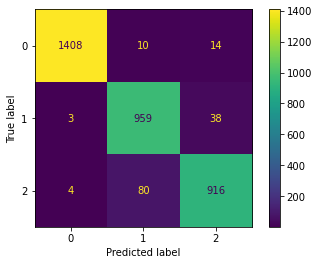

(array([0, 1, 2]), array([1406, 1039,  987]))
Accuracy Score: 95.22144522144522


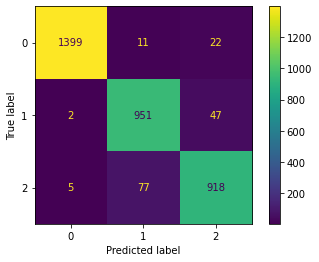

(array([0, 1, 2]), array([1448,  975, 1009]))
Accuracy Score: 95.54195804195804


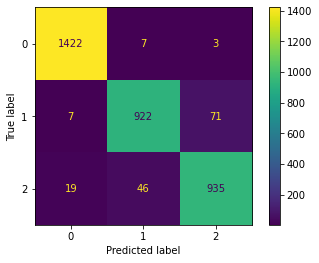

(array([0, 1, 2]), array([1414, 1016, 1002]))
Accuracy Score: 95.97902097902097


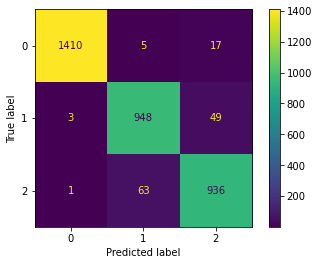

(array([0, 1, 2]), array([1419,  996, 1017]))
Accuracy Score: 95.6002331002331


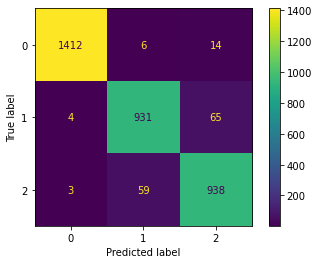

In [124]:
ensemble_model(denseNet_valid, [1], valid_data.labels ) #Accuracy Score: 95.65850815850816 
ensemble_model(denseNet_valid_bl, [1], valid_data.labels) #Accuracy Score: 95.22144522144522
ensemble_model(efficientNet_1422_valid, [1], valid_data.labels) #Accuracy Score: 95.54195804195804
ensemble_model(efficient_Net_best_loss_valid, [1], valid_data.labels) #Accuracy Score: 95.97902097902097
ensemble_model(efficientNet_orig_valid, [1], valid_data.labels) #Accuracy Score: 95.6002331002331

(array([0, 1, 2]), array([1417, 1017,  998]))
Accuracy Score: 96.0081585081585


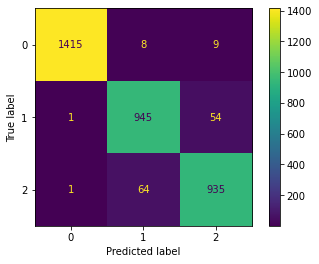

(array([0, 1, 2]), array([397, 422, 381]))


In [177]:
#Average
A = [denseNet_valid,denseNet_valid_bl,efficientNet_1422_valid,efficient_Net_best_loss_valid,efficientNet_orig_valid]
ensemble_model(A, len(A)*[1], valid_data.labels)
ensemble_model(B, [1,1,1,1,1], None, en_type=None)

(array([0, 1, 2]), array([1420, 1014,  998]))
Accuracy Score: 96.0955710955711


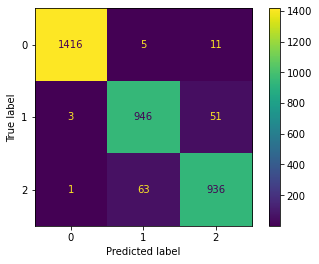

In [125]:
ensemble_model(A, [1,0,0,1,1], valid_data.labels)

(array([0, 1, 2]), array([1420, 1017,  995]))
Accuracy Score: 96.27039627039628


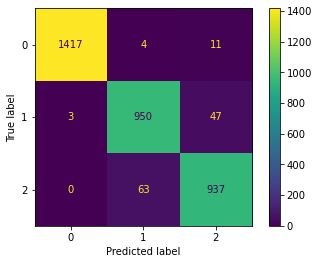

In [137]:
ensemble_model(A, [.3,0,0,.5,.2], valid_data.labels)

(array([0, 1, 2]), array([1426, 1011,  995]))
Accuracy Score: 96.35780885780886


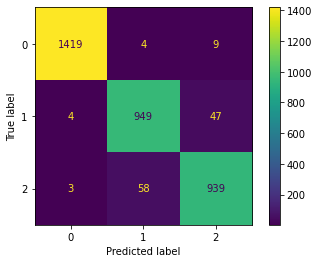

(array([0, 1, 2]), array([399, 415, 386]))
Enter the nameeidth_0_0_.4_.5_.1


In [213]:
ensemble_model(A, [0,0,.4,.5,.1], valid_data.labels) #Maybe??
ensemble_model(B, [0,0,.4,.5,0], None, en_type='test') #Yes it worked giving probab

(array([0, 1, 2]), array([1419, 1009, 1004]))
Accuracy Score: 96.0955710955711


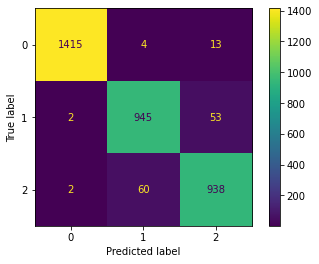

(array([0, 1, 2]), array([401, 412, 387]))


In [212]:
ensemble_model(A, [0,0,0,1,1.2], valid_data.labels) #
ensemble_model(B, [0,0,0,1,1.2], None, en_type=None)

In [210]:
1+12+13

26